# ロールプレイ:循環水に薬品の投入を判断する業務
A発電所内では、ある装置群の冷却のために水を循環利用しています。 水に雑菌が繁殖しないよう毎日ある化学物質Aを投入しています。 また、Aを食料としてしまう雑菌を抑えるため、不定期に化学物質Bを 投入しています(Bは錠剤型で、1粒だけ投入します)。<br>
毎日の化学物質Aの投入量、化学物質Bの投入判断は、前日の装置稼働 状況、前日の平均気温、降水量、日照時間を基に、熟練工の判断により 決めてきました。この熟練工の方が定年が近づいてきましたが発電所の 人手不足の影響で、業務を引き継いでくれる工員がいない状況です。

---
以下のようなデータを用いて、発電所の問題を解決してください。
### 化学物質投入履歴データ(chemicals.csv)
翌日に投入する化学物質の量を記録
* Date:日付
* Chemical-A:翌日の化学物質Aの投入量(mg)
* Chemical-B:翌日の化学物質B(錠剤1粒)の投入有無(1:投入、0:非投入)

### 天気データ(tenki.csv)
気象庁発表のA発電所の存在する市の天気 
* Date:日付
* Temperature:平均気温
* Precipitation:降水量
* SunshineTime:日照時間 

### カレンダーデータ(calender.csv)
内閣府発表の祝日データ。装置の稼働状況データはないため、参考として。
* Date:日付
* Weekday:曜日
* PublicHoliday :祝日

---

In [358]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

## データ読み込み

In [359]:
chemicals = pd.read_csv('./data/chemicals.csv')
chemicals

,Date,Chemicals-A,Chemicals-B
0,2016/4/1,28.0,0
1,2016/4/2,23.5,0
2,2016/4/3,27.1,0
3,2016/4/4,27.2,0
4,2016/4/5,24.5,0
...,...,...,...
725,2018/3/27,32.9,1
726,2018/3/28,35.7,1
727,2018/3/29,37.2,1
728,2018/3/30,30.3,1


---
#### Bのデータは投入するまでAの総量と関係しているのではないか？？

---

* 上記はあまり関係ない値となった

In [360]:
tenki = pd.read_csv('./data/tenki.csv')
tenki

,Date,Temperature,Precipitation,SunshineTime
0,2016/4/1,12.4,0.0,2.1
1,2016/4/2,10.7,1.0,0.0
2,2016/4/3,13.4,3.5,0.4
3,2016/4/4,14.6,19.5,0.6
4,2016/4/5,10.7,2.5,0.0
...,...,...,...,...
725,2018/3/27,15.3,0.0,8.2
726,2018/3/28,17.0,0.0,10.5
727,2018/3/29,18.3,0.0,10.7
728,2018/3/30,13.6,0.0,11.4


In [361]:
calender = pd.read_csv('./data/calender.csv')
calender

,Date,Weekday,PublicHoliday
0,2016/4/1,Fri,NaN
1,2016/4/2,Sat,NaN
2,2016/4/3,Sun,NaN
3,2016/4/4,Mon,NaN
4,2016/4/5,Tue,NaN
...,...,...,...
725,2018/3/27,Tue,NaN
726,2018/3/28,Wed,NaN
727,2018/3/29,Thu,NaN
728,2018/3/30,Fri,NaN


### データのマージ

In [362]:
chemicals_tenki = pd.merge(chemicals, tenki)
original_df = pd.merge(chemicals_tenki, calender)
original_df

,Date,Chemicals-A,Chemicals-B,Temperature,Precipitation,SunshineTime,Weekday,PublicHoliday
0,2016/4/1,28.0,0,12.4,0.0,2.1,Fri,NaN
1,2016/4/2,23.5,0,10.7,1.0,0.0,Sat,NaN
2,2016/4/3,27.1,0,13.4,3.5,0.4,Sun,NaN
3,2016/4/4,27.2,0,14.6,19.5,0.6,Mon,NaN
4,2016/4/5,24.5,0,10.7,2.5,0.0,Tue,NaN
...,...,...,...,...,...,...,...,...
725,2018/3/27,32.9,1,15.3,0.0,8.2,Tue,NaN
726,2018/3/28,35.7,1,17.0,0.0,10.5,Wed,NaN
727,2018/3/29,37.2,1,18.3,0.0,10.7,Thu,NaN
728,2018/3/30,30.3,1,13.6,0.0,11.4,Fri,NaN


### データの処理

In [363]:
df = original_df.copy(deep=True)

## 欠損値を０で補完
df.fillna(0, inplace=True)
## 祝日を１として数値化
df['PublicHoliday'] = df['PublicHoliday'].apply(lambda ph: 0 if ph == 0 else 1)

## 月のデータを利用 | 数値化
df["Date"] = df["Date"].apply(pd.to_datetime)
df["Date"] = df["Date"].apply(lambda dt: dt.month)

## 月と曜日をOneHotEncoding
weekday = pd.get_dummies(df["Weekday"])
df = df.join(weekday, how="inner")

month = pd.get_dummies(df["Date"])
df = df.join(month, how="inner")

## Weekday削除
df.drop(["Weekday"], axis=1, inplace=True)
## 日付削除
df.drop(["Date"], axis=1, inplace=True)

df

,Chemicals-A,Chemicals-B,Temperature,Precipitation,SunshineTime,PublicHoliday,Fri,Mon,Sat,Sun,...,3,4,5,6,7,8,9,10,11,12
0,28.0,0,12.4,0.0,2.1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,23.5,0,10.7,1.0,0.0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,27.1,0,13.4,3.5,0.4,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,27.2,0,14.6,19.5,0.6,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,24.5,0,10.7,2.5,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,32.9,1,15.3,0.0,8.2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
726,35.7,1,17.0,0.0,10.5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
727,37.2,1,18.3,0.0,10.7,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
728,30.3,1,13.6,0.0,11.4,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## データ分析

In [364]:
print("データ総数：", len(df))
print("正例 B：", df["Chemicals-B"].sum())
print("正例 B の割合 ：{:.2%}".format(df["Chemicals-B"].sum()/len(df)))

データ総数： 730
正例 B： 286
正例 B の割合 ：39.18%


In [365]:
df.describe()

,Chemicals-A,Chemicals-B,Temperature,Precipitation,SunshineTime,PublicHoliday,Fri,Mon,Sat,Sun,...,3,4,5,6,7,8,9,10,11,12
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,...,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,32.101918,0.391781,15.859315,4.257534,5.400274,0.043836,0.143836,0.142466,0.143836,0.142466,...,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,0.084932,0.082192,0.084932
std,12.564793,0.488483,8.328433,13.489801,4.026030,0.204870,0.351164,0.349767,0.351164,0.349767,...,0.278971,0.274845,0.278971,0.274845,0.278971,0.278971,0.274845,0.278971,0.274845,0.278971
min,2.100000,0.000000,-1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.500000,0.000000,8.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32.300000,0.000000,16.350000,0.000000,5.900000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,42.975000,1.000000,23.075000,1.500000,8.800000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58.100000,1.000000,32.300000,145.500000,13.400000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


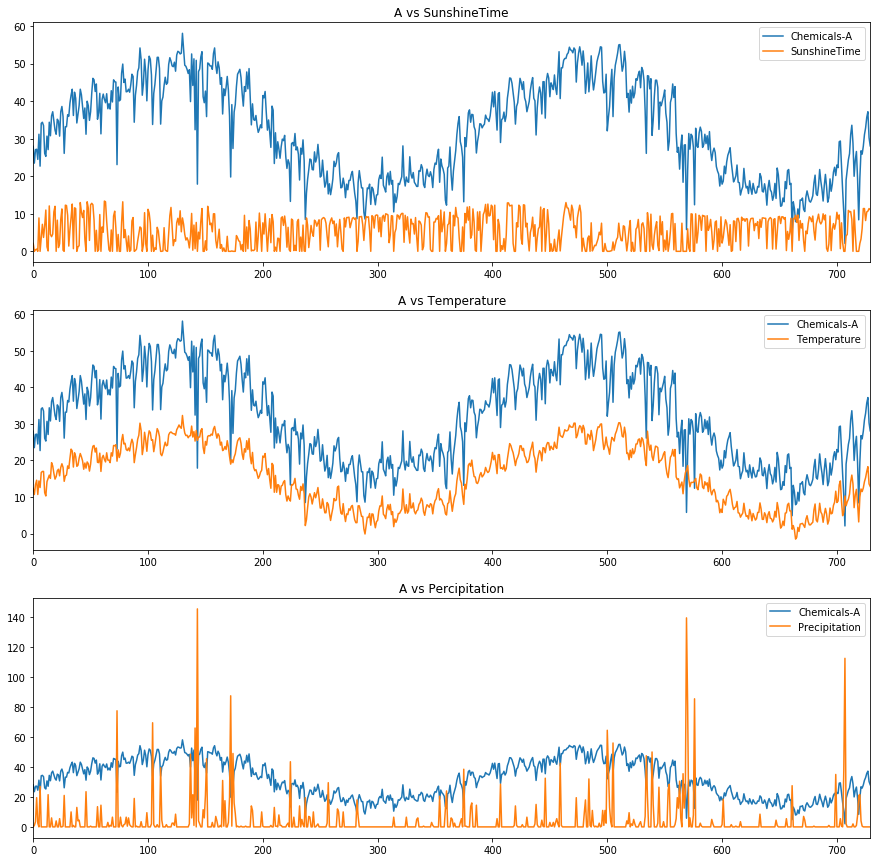

In [366]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
df.plot(y=["Chemicals-A", "SunshineTime"], title="A vs SunshineTime",ax=ax1)
df.plot(y=["Chemicals-A", "Temperature"], title="A vs Temperature", ax=ax2)
df.plot(y=["Chemicals-A", "Precipitation"], title="A vs Percipitation", ax=ax3);

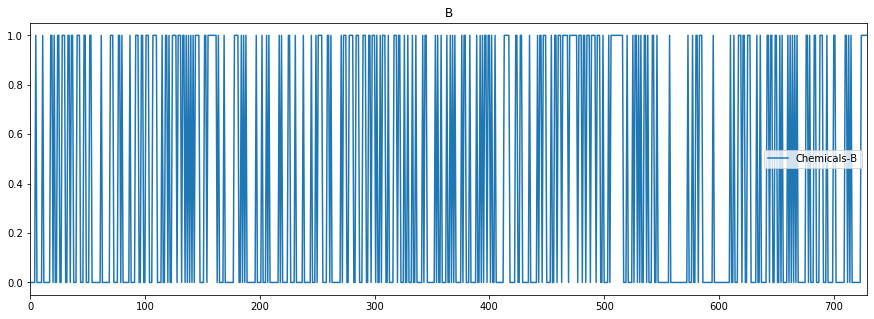

In [367]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df.plot(y=["Chemicals-B"], title="B",ax=ax);

### 相関係数

In [368]:
df.corr().style.background_gradient(axis=None)

,Chemicals-A,Chemicals-B,Temperature,Precipitation,SunshineTime,PublicHoliday,Fri,Mon,Sat,Sun,Thu,Tue,Wed,1,2,3,4,5,6,7,8,9,10,11,12
Chemicals-A,1,0.264406,0.973105,-0.148434,-0.00441383,-0.0124491,0.00516036,0.00702314,-0.0244364,-0.00936379,-0.00118593,0.00827167,0.014608,-0.396321,-0.335209,-0.230665,-0.0297576,0.170501,0.237809,0.39208,0.367425,0.260371,0.0333742,-0.165646,-0.314687
Chemicals-B,0.264406,1,0.198475,-0.221525,0.550624,-0.0210676,0.0228948,0.00204567,-0.0090922,-0.0300691,0.0100744,0.0421891,-0.0380978,0.0675399,-0.0099089,-0.043188,-0.0460477,0.00714284,-0.056265,0.158135,0.148069,0.0356905,-0.14385,-0.117569,-0.00292333
Temperature,0.973105,0.198475,1,0.0781461,-0.105865,0.00233301,-0.0110823,0.0156957,-0.00789286,0.00938566,-0.00168054,0.00397028,-0.00832026,-0.420001,-0.357482,-0.228415,-0.0334745,0.160013,0.235597,0.395467,0.401843,0.280722,0.0615335,-0.173763,-0.333684
Precipitation,-0.148434,-0.221525,0.0781461,1,-0.332174,0.021968,-0.0265078,0.0672213,-0.0149249,-0.0159272,0.0333514,0.0276822,-0.0707296,-0.073072,-0.0811087,0.0235228,-0.0162614,-0.0471919,-0.0175563,0.000923256,0.12759,0.0701291,0.112281,-0.0393852,-0.0635948
SunshineTime,-0.00441383,0.550624,-0.105865,-0.332174,1,0.0352431,0.0240344,-0.0244784,0.0581874,0.0211109,0.00123861,-0.0113277,-0.0690936,0.128586,0.0936304,0.0505427,0.028864,0.100496,-0.0415495,-0.0191958,-0.132536,-0.134525,-0.135101,-0.0275412,0.089992
PublicHoliday,-0.0124491,-0.0210676,0.00233301,0.021968,0.0352431,1,0.00757462,0.10416,-0.0114925,-0.0489858,0.0275873,-0.0681291,-0.0106993,0.0307744,-0.0114343,-0.0172284,-0.0153512,0.0787771,-0.0640745,-0.0172284,-0.0172284,0.0333722,-0.0172284,0.0333722,-0.0172284
Fri,0.00516036,0.0228948,-0.0110823,-0.0265078,0.0240344,0.00757462,1,-0.167064,-0.168,-0.167064,-0.167064,-0.167064,-0.167064,-0.0128516,-0.000803714,0.0151533,0.00525673,-0.0128516,0.00525673,0.00115089,-0.0128516,0.0194694,-0.0128516,-0.00895592,0.0151533
Mon,0.00702314,0.00204567,0.0156957,0.0672213,-0.0244784,0.10416,-0.167064,1,-0.167064,-0.166134,-0.166134,-0.166134,-0.166134,0.0164079,0.000322769,-0.0117089,-0.00781885,0.0164079,-0.00781885,0.00234948,0.00234948,-0.00781885,0.0164079,-0.00781885,-0.0117089
Sat,-0.0244364,-0.0090922,-0.00789286,-0.0149249,0.0581874,-0.0114925,-0.168,-0.167064,1,-0.167064,-0.167064,-0.167064,-0.167064,-0.0128516,-0.000803714,0.00115089,0.0194694,-0.0128516,-0.00895592,0.0151533,-0.0128516,0.00525673,0.00115089,-0.00895592,0.0151533
Sun,-0.00936379,-0.0300691,0.00938566,-0.0159272,0.0211109,-0.0489858,-0.167064,-0.166134,-0.167064,1,-0.166134,-0.166134,-0.166134,0.00234948,0.000322769,-0.0117089,0.00645055,0.00234948,-0.00781885,0.0164079,-0.0117089,-0.00781885,0.0164079,-0.00781885,0.00234948


* 温度と薬品Aにはかなり高い正の相関がある (0.973195)
* 日照時間と薬品Bには正の相関がある (0.550624)

In [369]:
df.nunique()

Chemicals-A      356
Chemicals-B        2
Temperature      273
Precipitation     75
SunshineTime     132
PublicHoliday      2
Fri                2
Mon                2
Sat                2
Sun                2
Thu                2
Tue                2
Wed                2
1                  2
2                  2
3                  2
4                  2
5                  2
6                  2
7                  2
8                  2
9                  2
10                 2
11                 2
12                 2
dtype: int64

## データ前処理

In [370]:
# データ分割を行う便利なモジュール train_test_split をインポート
from sklearn.model_selection import train_test_split

# データの標準化を行うためのモジュールをインポート
from sklearn.preprocessing import StandardScaler

In [371]:
def preprocess(df):
    columnList = df.columns.tolist()
    ## 削除するもの
#   columnList.remove("")

    ## 目的変数なので削除
    columnList.remove("Chemicals-B")

    X = pd.DataFrame( df.loc[:, columnList] )
    y = pd.DataFrame( df.loc[:, ["Chemicals-B"]] )
    
    return X, y

## --------------------------------------
## 使用データ決定
X, y = preprocess(df)

## ------
# データを訓練用データ・検証用データに分ける (訓練：検証　＝ 7:3)
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.3, random_state=1234)

print('===== B =====')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

===== B =====
(511, 24)
(511, 1)
(219, 24)
(219, 1)


#### 変数の標準化  
各変数、当該変数の平均値を引いてから、当該変数の標準偏差で割ります。（標準化）
変数のスケールを揃えるために実行しています。

In [372]:
# 説明変数を標準化（平均0、標準偏差1となるように変数変換）する
# 標準偏差と正規化 http://ailaby.com/scaler/

def standard(X_train, X_test):
    sclr_X = StandardScaler()
    sclr_X.fit(X_train)
    X_train = sclr_X.transform(X_train)
    X_test = sclr_X.transform(X_test)
    
    return X_train, X_test

## 不均衡データ処理

### SMOTE オーバーサンプリング
不均衡データ（0と1がアンバランス）な場合、比率を調整しておくことで、Precision や Recall が悪いモデルが構築されるのを避ける事ができます。

SMOTE メソッドは 0 と 1 の比率を予め指定してから、説明変数・目的変数をセットで入力すると、数の少ない方のサンプルをオーバーサンプリングし、 **0 と 1 の比率を 1 : 1**にしてくれます。

オーバーサンプリング時に、元サンプルのうち比較的近い値をもつデータを何点かつかって（個数は k_neighbors で指定）、「何点かのデータからアルゴリズム※に従って生成した説明変数」「オーバーサンプリングする側の値を目的変数」とした新たなサンプル（元データに無いサンプル）を生成します。

In [373]:
# SMOTE用のライブラリをインポート
from imblearn.over_sampling import SMOTE

In [374]:
def SMOTESampling(X_train, y_train):
    print("\n==== (SMOTE) オーバーサンプリングを行う")
    ## サンプル生成に使用するサンプル数 k_neighbors
    smote_s = SMOTE( k_neighbors=3, random_state=1234)
    print(smote_s)
    
    ## 学習用データに反映
    X_train, y_train = smote_s.fit_sample(X_train, y_train)
    
    # サンプリング結果を表示
    print( "-----------------------------------------------------" )
    print( "サンプリング後の説明変数の数と件数：" + str(X_train.shape) )
    print( "サンプリング後の目的変数の数と件数：" + str(y_train.shape) )
    print( "-----------------------------------------------------" )
    print( "サンプリング後の目的変数＝ 0 の件数：" + str(int(y_train.shape[0] - y_train.sum()) ))
    print( "サンプリング後の目的変数＝ 1 の件数：" + str(int(y_train.sum()) ))
    print( "-----------------------------------------------------" )
    
    return X_train, y_train

## クロスバリデーション

**データ**

* 学習データ:テストデータ = 7:3
* <s>学習データ(学習):学習データ(テスト) = 8:2 (cv=5)</s>

## 精度検証

In [375]:
# 正解率を作成するためのモジュールをインポート
from sklearn.metrics import accuracy_score

# 混合行列を作成するためのモジュールをインポート
from sklearn.metrics import confusion_matrix

# ROCを作成する
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

---

#### ROC曲線
ROC (Receiver Operating Characteristic) curve

検査や診断薬の性能を2次元のグラフに表したもの。当該検査で異常と正常を区別するカットオフポイントごとに真陽性率（=TPF）と偽陽性率（=FPF）を計算し、縦軸にTPF、横軸にFPFをとった平面にプロットして線で結んで表す。

ROC曲線を作成した時に、グラフの下の部分の面積をAUC（Area Under the Curve）とよぶ。AUCは0から1までの値をとり、値が1に近いほど判別能が高いことを示す。

---
#### predict(X)
* [データ数]行 × [次元数]列の特徴量行列 X を引数にして、データ数分の予測ラベルを返す

#### predict_proba(X)
* [データ数]行 × [次元数]列の特徴量行列 X を引数にして、各データがそれぞれのクラスに所属する確率を返す。「列はクラス名でソートされていて、そのクラス名は classes_で見れる」

---

#### ROC曲線を算出・プロット: roc_curve()

ROC曲線の算出にはsklearn.metricsモジュールのroc_curve()関数を使う。

sklearn.metrics.roc_curve — scikit-learn 0.20.3 documentation
第一引数に正解クラス、第二引数に予測スコアのリストや配列をそれぞれ指定する。

予測スコアは機械学習のモデルなどによって予測された確率で、例えば1.0だと100%の確率で1だと予測、0.8だと80%の確率で1だと予測しているという意味合いの値。

roc_curve()は3つの要素を持つタプルを返す。
* 3つの要素は順番にfpr, tpr, thresholdsで、それぞれFPR（偽陽性率）、TPR（真陽性率）、閾値
* 閾値：クラス０or１を分けるときの基準値 [配列]

---

In [376]:
result = pd.DataFrame(columns=["訓練精度%", "検証精度%", "AUC(訓練)", "AUC(検証)", "AUC rate", "訓練(TN 0->0)%", "訓練(FP 0->1)%", "訓練(FN 1->0)%", "訓練(TP 1->1)%", "検証(TN 0->0)%", "検証(FP 0->1)%", "検証(FN 1->0)%", "検証(TP 1->1)%" ])

# idx = result["タイトル"].values.tolist().index("a")
# result.drop(index=idx, inplace=True)
result

,訓練精度%,検証精度%,AUC(訓練),AUC(検証),AUC rate,訓練(TN 0->0)%,訓練(FP 0->1)%,訓練(FN 1->0)%,訓練(TP 1->1)%,検証(TN 0->0)%,検証(FP 0->1)%,検証(FN 1->0)%,検証(TP 1->1)%


In [377]:
result = result

def accuracy(title, clf, X_train, y_train, X_test, y_test):
    if title in result.index.tolist():
        result.drop(index=title, inplace=True)
        
    appendlst = [0]*13
    
    print("\n===  精度検証（訓練用データを確認）")
    print(accuracy_score(y_train, clf.predict(X_train)))
    conf_mtrx_df = pd.DataFrame(confusion_matrix(y_train, clf.predict(X_train).reshape(-1, 1)))
    conf_mtrx_df.rename(columns={0: 'predict(0)', 1: 'predict(1)'}, index={0: 'target(0)', 1: 'target(1)'}, inplace=True)
    display(conf_mtrx_df)
    
    appendlst[0] = accuracy_score(y_train, clf.predict(X_train))*100
    appendlst[5:7] = (conf_mtrx_df.loc['target(0)', :]*100/sum(conf_mtrx_df.loc['target(0)', :])).tolist()
    appendlst[7:9] = (conf_mtrx_df.loc['target(1)', :]*100/sum(conf_mtrx_df.loc['target(1)', :])).tolist()
    
    print("\n===  精度検証（検証用データを確認）")
    print(accuracy_score(y_test, clf.predict(X_test)))
    conf_mtrx_df = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test).reshape(-1, 1)))
    conf_mtrx_df.rename(columns={0: 'predict(0)', 1: 'predict(1)'}, index={0: 'target(0)', 1: 'target(1)'}, inplace=True)
    display(conf_mtrx_df)
    
    appendlst[1] = accuracy_score(y_test, clf.predict(X_test))*100
    appendlst[9:11] = (conf_mtrx_df.loc['target(0)', :]*100/sum(conf_mtrx_df.loc['target(0)', :])).tolist()
    appendlst[11:13] = (conf_mtrx_df.loc['target(1)', :]*100/sum(conf_mtrx_df.loc['target(1)', :])).tolist()
    
    print("\n ==== ROC ")
    # 訓練用データ
    # FPR TPR (閾値) AUC を算出
    y_train_predict = clf.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
    auc_value_train = auc(fpr_train, tpr_train)
    ## ROC をプロット
    plt.plot(fpr_train, tpr_train, label='ROC curve (area = %.2f)'%auc_value_train )
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    print('AUC(train): '+str(auc_value_train))
    
    
    # 検証用データ
    # FPR、TPR、（閾値）、AUCを算出
    y_test_predict = clf.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)
    auc_value_test = auc(fpr_test, tpr_test)
    ## ROC曲線をプロット
    plt.plot(fpr_test, tpr_test, label='ROC curve (area = %.2f)'%auc_value_test)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    print("AUC(test): "+str(auc_value_test))
    print("AUC ratio(train/test): "+str(auc_value_train/auc_value_test))
    
    appendlst[2:5] = [auc_value_train, auc_value_test, (auc_value_train/auc_value_test)]
    
    
    result.loc[title] = appendlst

# ロジスティック回帰
ロジスティック回帰モデルをつくります。
ロジスティック回帰モデルを作成するときは、以下のパラメータを（一部でいいので）設定する必要があります。
*   fit_intercept：切片を入れるか？
*   penalty：正則化の方法を指定するパラメータ l1 か l2 を指定。（Lassoを実施する際はL1正則化項を入れたいのでl1を指定する）
*   solver：Lasso回帰を実施する際は 'liblinear' を指定する必要がある。（計算をする際に「ソルバー」という機能が必要なのですが、デフォルトのソルバーはL2用なので変更してあげる必要があります。）
*   C：正則化の強さを指定するパラメータ。正の値を指定する（デフォルト値は1.0）。Cの値が小さいほど、強く正則化する。

In [378]:
# ロジスティック回帰を行うためのモジュールをインポート
from sklearn.linear_model import LogisticRegression


===  精度検証（訓練用データを確認）
0.8473581213307241


,predict(0),predict(1)
target(0),274,35
target(1),43,159



===  精度検証（検証用データを確認）
0.8721461187214612


,predict(0),predict(1)
target(0),120,15
target(1),13,71



 ==== ROC 
AUC(train): 0.9191899772501523
AUC(test): 0.9249559082892416
AUC ratio(train/test): 0.9937662638971043


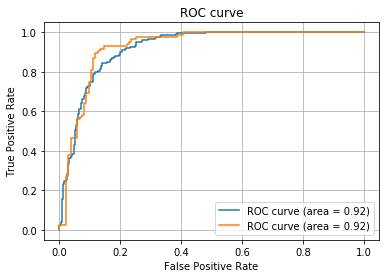

In [379]:
## 標準化
X_train_std, X_test_std = standard(X_train, X_test)
## 学習
clf = LogisticRegression(C=1000)
clf.fit(X_train_std, y_train)
## 精度を表示
accuracy("Logistic", clf, X_train_std, y_train, X_test_std, y_test)


==== (SMOTE) オーバーサンプリングを行う
SMOTE(k_neighbors=3, random_state=1234)
-----------------------------------------------------
サンプリング後の説明変数の数と件数：(618, 24)
サンプリング後の目的変数の数と件数：(618, 1)
-----------------------------------------------------
サンプリング後の目的変数＝ 0 の件数：309
サンプリング後の目的変数＝ 1 の件数：309
-----------------------------------------------------

===  精度検証（訓練用データを確認）
0.8673139158576052


,predict(0),predict(1)
target(0),271,38
target(1),44,265



===  精度検証（検証用データを確認）
0.8721461187214612


,predict(0),predict(1)
target(0),119,16
target(1),12,72



 ==== ROC 
AUC(train): 0.9414857406185524
AUC(test): 0.9271604938271605
AUC ratio(train/test): 1.0154506656471738


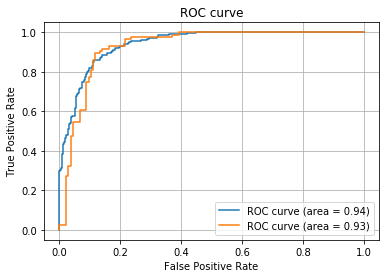

In [380]:
## (SMOTE) オーバーサンプリング
X_train_smp, y_train_smp = SMOTESampling(X_train, y_train)
## 標準化
X_train_smp_std, X_test_std = standard(X_train_smp, X_test)
## 学習
clf = LogisticRegression(C=1000)
clf.fit(X_train_smp_std, y_train_smp)
## 精度を表示
accuracy("Logistic_SMOTE", clf, X_train_smp_std, y_train_smp, X_test_std, y_test)

## Decision Tree Classifier

決定木モデルをつくります。
決定木モデルを作成するときは、以下のパラメータを（一部でいいので）設定する必要があります。
*   class_weight：予測するクラスに対して重要度の重みを付ける場合に使う引数ですが、原則 None（重みは平等）で結構です。
*   criterion：分割を決定するのに用いる不純度を決めます。'gini'ならばジニ係数、'entropy'ならばエントロピーを不純度として用います。
*   max_depth：木の最大深さを決めます。Noneの場合は全ての葉が純粋（単独クラス）になるまで木が成長します。（他のパラメータによって停止される可能性はある）
*   max_features：使用する変数の数の上限を決めます。
*   max_leaf_nodes：最大の葉の数をきめます。ここで指定した葉の数以内で、もっともcriterionが低くなるように木が成長します。
*   min_impurity_decrease：ここで設定した値以上のcriterionの減少を引き起こす場合のみ、ノードは分割されるようになります。（criterionの減少に効果的ではない分割が発生しないようになります。）
*   min_impurity_split：使われなくなった引数です。原則、設定しません。（Scikit-learn 0.19以降）
*   min_samples_leaf：１つの葉に必要なサンプルの最小数。ここで指定するよりも小さなサンプル数になってしまう葉は生成させません。
*   min_samples_split：ノードを分割するために必要なサンプルの最小数。ここで指定するよりも小さなサンプル数のノードは分割されません。
*   min_weight_fraction_leaf：葉に必要な（すべての入力サンプルの）重みの合計の最小加重部分。原則、設定不要です。
*   presort：分割の閾値の発見を早めるためにデータを事前にソートしておくかを決めますが、大きいデータだとソートに時間がかかるため、かえって速度が遅くなる可能性もあります。原則、設定不要です。
*   random_state：分割の閾値を決めるときに乱数をしようする場合があり、その際のシードの値を入力します。（値を定めておくと処理の再現性が得られます）
*   splitter：分割の閾値を決める場合に使うアルゴリズムを選択します。原則、設定不要です。

In [381]:
# 決定木構築用クラスをインポート
from sklearn.tree import DecisionTreeClassifier

# 決定木可視化用モジュール群をインポート
from sklearn.tree import export_graphviz


===  精度検証（訓練用データを確認）
0.9432485322896281


,predict(0),predict(1)
target(0),280,29
target(1),0,202



===  精度検証（検証用データを確認）
0.8995433789954338


,predict(0),predict(1)
target(0),119,16
target(1),6,78



 ==== ROC 
AUC(train): 0.96801403441315
AUC(test): 0.9019400352733687
AUC ratio(train/test): 1.0732576408139538


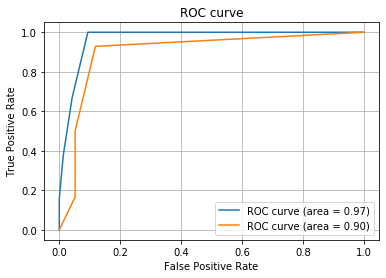

In [382]:
## 標準化
X_train_std, X_test_std = standard(X_train, X_test)
## 学習
clf = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=10, random_state=1234)
clf.fit(X_train_std, y_train)
## 精度を表示
accuracy("Tree", clf, X_train_std, y_train, X_test_std, y_test)


==== (SMOTE) オーバーサンプリングを行う
SMOTE(k_neighbors=3, random_state=1234)
-----------------------------------------------------
サンプリング後の説明変数の数と件数：(618, 24)
サンプリング後の目的変数の数と件数：(618, 1)
-----------------------------------------------------
サンプリング後の目的変数＝ 0 の件数：309
サンプリング後の目的変数＝ 1 の件数：309
-----------------------------------------------------

===  精度検証（訓練用データを確認）
0.9498381877022654


,predict(0),predict(1)
target(0),280,29
target(1),2,307



===  精度検証（検証用データを確認）
0.9178082191780822


,predict(0),predict(1)
target(0),121,14
target(1),4,80



 ==== ROC 
AUC(train): 0.9578293063541439
AUC(test): 0.9201499118165783
AUC ratio(train/test): 1.0409491910542903


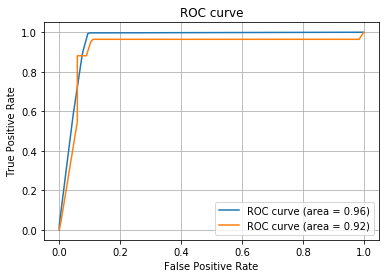

In [383]:
## (SMOTE) オーバーサンプリング
X_train_smp, y_train_smp = SMOTESampling(X_train, y_train)
## 標準化
X_train_smp_std, X_test_std = standard(X_train_smp, X_test)
## 学習
clf = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=10, random_state=1234)
clf.fit(X_train_smp_std, y_train_smp)
## 精度を表示
accuracy("Tree_SMOTE", clf, X_train_smp_std, y_train_smp, X_test_std, y_test)

In [384]:
xlist = X_train.columns.astype(str)

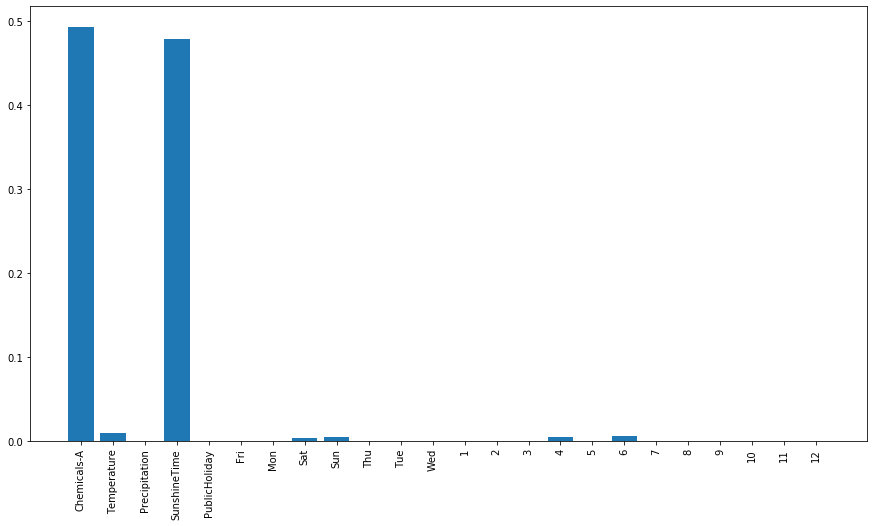

In [385]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.bar(x=xlist, height=clf.feature_importances_)
ax.set_xticklabels(xlist, rotation=90);

## サポートベクターマシーン

SVMで線形判別モデルをつくります。
SVMでモデルを作成するときは、以下のパラメータを（一部でいいので）設定する必要があります。
*   C：ソフトマージンの厳しさを表すパラメータ（デフォルト1.0、データ解析者が決めるハイパーパラメータ）
*   kernel：カーネル関数を指定する（カーネルトリックを使わない際は linear、使う際は rbf などを指定する）
*   gamma：カーネルトリックを使う際のパラメータ（、データ解析者が決めるハイパーパラメータ）
*   probability：確率をアウトプットする際はTrueにする。（デフォルトFalse）

In [386]:
# サポートベクターマシンを行うためのモジュールをインポート
from sklearn.svm import SVC


===  精度検証（訓練用データを確認）
0.8786692759295499


,predict(0),predict(1)
target(0),270,39
target(1),23,179



===  精度検証（検証用データを確認）
0.8264840182648402


,predict(0),predict(1)
target(0),114,21
target(1),17,67



 ==== ROC 
AUC(train): 0.9371895927456824
AUC(test): 0.9132716049382716
AUC ratio(train/test): 1.0261893479202469


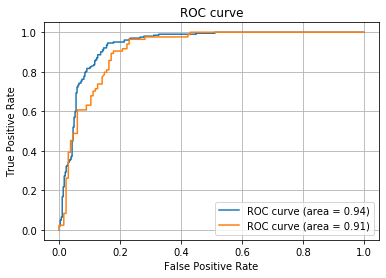

In [387]:
## 標準化
X_train_std, X_test_std = standard(X_train, X_test)
## 学習
clf = SVC(C=10, kernel='rbf', gamma=0.005, probability=True, random_state=5678)
clf.fit(X_train_std, y_train)
## 精度を表示
accuracy("SVM", clf, X_train_std, y_train, X_test_std, y_test)


==== (SMOTE) オーバーサンプリングを行う
SMOTE(k_neighbors=3, random_state=1234)
-----------------------------------------------------
サンプリング後の説明変数の数と件数：(618, 24)
サンプリング後の目的変数の数と件数：(618, 1)
-----------------------------------------------------
サンプリング後の目的変数＝ 0 の件数：309
サンプリング後の目的変数＝ 1 の件数：309
-----------------------------------------------------

===  精度検証（訓練用データを確認）
0.901294498381877


,predict(0),predict(1)
target(0),265,44
target(1),17,292



===  精度検証（検証用データを確認）
0.8356164383561644


,predict(0),predict(1)
target(0),110,25
target(1),11,73



 ==== ROC 
AUC(train): 0.9494349661189136
AUC(test): 0.9168430335097001
AUC ratio(train/test): 1.0355479961323921


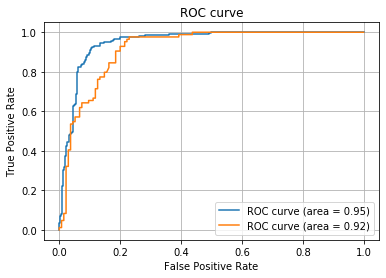

In [388]:
## アンダーサンプリング
X_train_smp, y_train_smp = SMOTESampling(X_train, y_train)
## 標準化
X_train_smp_std, X_test_std = standard(X_train_smp, X_test)
## 学習
clf = SVC(C=10, kernel='rbf', gamma=0.005, probability=True, random_state=5678)
clf.fit(X_train_smp_std, y_train_smp)
## 精度を表示
accuracy("SVM_SMOTE", clf, X_train_smp_std, y_train_smp, X_test_std, y_test)

# ランダムフォレスト
*   criterion：分割を決定するのに用いる不純度を決めます。'gini'ならばジニ係数、'entropy'ならばエントロピーを不純度として用います。
*   max_leaf_nodes：最大の葉の数をきめます。ここで指定した葉の数以内で、もっともcriterionが低くなるように木が成長します。
*   n_estimators：弱学習器の数を指定します。
*   random_state：分割の閾値を決めるときに乱数をしようする場合があり、その際のシードの値を入力します。（値を定めておくと処理の再現性が得られます）

In [389]:
# ランダムフォレスト用ライブラリをインポート
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_leaf_nodes=4, criterion='gini', n_estimators=100, random_state=1234)


===  精度検証（訓練用データを確認）
0.9197651663405088


,predict(0),predict(1)
target(0),275,34
target(1),7,195



===  精度検証（検証用データを確認）
0.908675799086758


,predict(0),predict(1)
target(0),119,16
target(1),4,80



 ==== ROC 
AUC(train): 0.9567192156108815
AUC(test): 0.9414462081128748
AUC ratio(train/test): 1.016222921040408


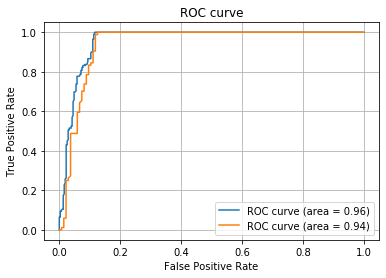

In [390]:
## 標準化
X_train_std, X_test_std = standard(X_train, X_test)
## 学習
clf.fit(X_train_std, y_train)
## 精度を表示
accuracy("RandomForest", clf, X_train_std, y_train, X_test_std, y_test)


==== (SMOTE) オーバーサンプリングを行う
SMOTE(k_neighbors=3, random_state=1234)
-----------------------------------------------------
サンプリング後の説明変数の数と件数：(618, 24)
サンプリング後の目的変数の数と件数：(618, 1)
-----------------------------------------------------
サンプリング後の目的変数＝ 0 の件数：309
サンプリング後の目的変数＝ 1 の件数：309
-----------------------------------------------------

===  精度検証（訓練用データを確認）
0.9401294498381877


,predict(0),predict(1)
target(0),273,36
target(1),1,308



===  精度検証（検証用データを確認）
0.9223744292237442


,predict(0),predict(1)
target(0),118,17
target(1),0,84



 ==== ROC 
AUC(train): 0.9564206491343828
AUC(test): 0.944268077601411
AUC ratio(train/test): 1.0128698320119445


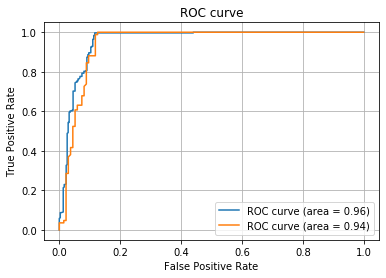

In [391]:
## SMOTE サンプリング
X_train_smp, y_train_smp = SMOTESampling(X_train, y_train)
## 標準化
X_train_smp_std, X_test_std = standard(X_train_smp, X_test)
## 学習
clf.fit(X_train_smp_std, y_train_smp)
## 精度を表示
accuracy("RandomForest_SMOTE", clf, X_train_smp_std, y_train_smp, X_test_std, y_test)

In [392]:
xlist = X_train.columns.astype(str)

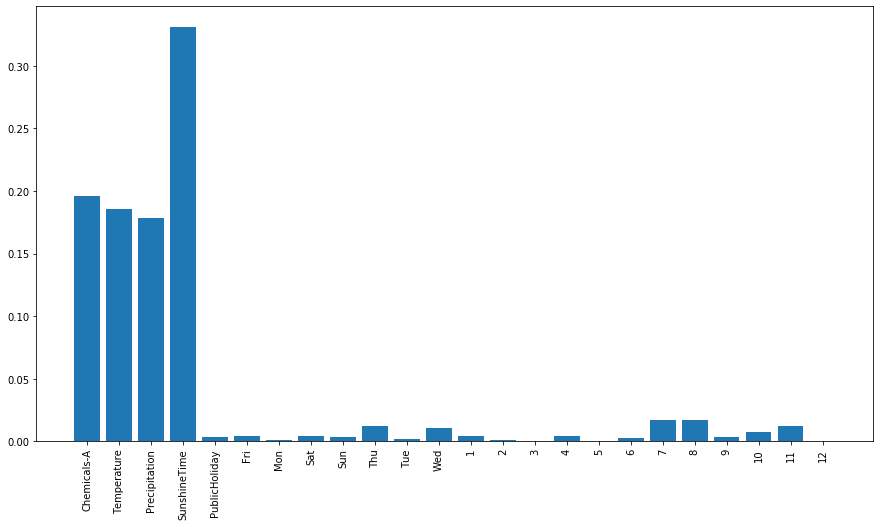

In [393]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.bar(x=xlist, height=clf.feature_importances_)
ax.set_xticklabels(xlist, rotation=90);

# LightGBM
*   num_leaves：決定木の葉の数を指定します。ここで指定した葉の数以内で木が成長します。
*   max_depth：最大の枝の深さをきめます。ここで指定した枝の深さ以内で木が成長します。
*   min_child_samples：１つの葉を構成するための最低サンプル数をきめます。ここで指定したサンプル数を下回る葉は作成されません。
*   n_estimators：弱学習器の数を指定します。
*   random_state：分割の閾値を決めるときに乱数をしようする場合があり、その際のシードの値を入力します。（値を定めておくと処理の再現性が得られます）

In [394]:
# LightGBM用ライブラリをインポート
from lightgbm import LGBMClassifier
clf = LGBMClassifier(num_leaves=4, max_depth=3, min_child_samples=10, n_estimators=100, andom_state=1234)


===  精度検証（訓練用データを確認）
0.9373776908023483


,predict(0),predict(1)
target(0),277,32
target(1),0,202



===  精度検証（検証用データを確認）
0.8995433789954338


,predict(0),predict(1)
target(0),116,19
target(1),3,81



 ==== ROC 
AUC(train): 0.992141689897145
AUC(test): 0.926984126984127
AUC ratio(train/test): 1.0702898367041118


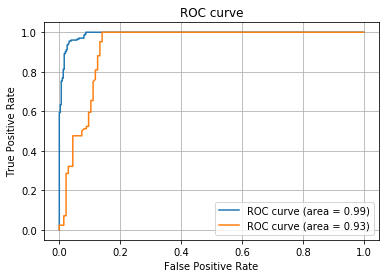

In [395]:
## 標準化
X_train_std, X_test_std = standard(X_train, X_test)
## 学習
clf.fit(X_train_std, y_train)
## 精度を表示
accuracy("LGBM", clf, X_train_std, y_train, X_test_std, y_test)


==== (SMOTE) オーバーサンプリングを行う
SMOTE(k_neighbors=3, random_state=1234)
-----------------------------------------------------
サンプリング後の説明変数の数と件数：(618, 24)
サンプリング後の目的変数の数と件数：(618, 1)
-----------------------------------------------------
サンプリング後の目的変数＝ 0 の件数：309
サンプリング後の目的変数＝ 1 の件数：309
-----------------------------------------------------

===  精度検証（訓練用データを確認）
0.948220064724919


,predict(0),predict(1)
target(0),277,32
target(1),0,309



===  精度検証（検証用データを確認）
0.908675799086758


,predict(0),predict(1)
target(0),118,17
target(1),3,81



 ==== ROC 
AUC(train): 0.9964076622574125
AUC(test): 0.9313492063492063
AUC ratio(train/test): 1.0698539875963697


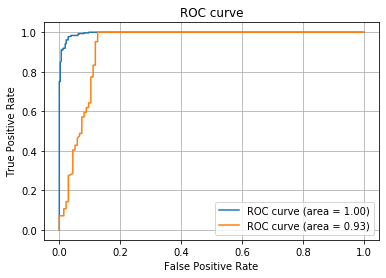

In [396]:
## オーバーサンプリング
X_train_smp, y_train_smp = SMOTESampling(X_train, y_train)
## 標準化
X_train_smp_std, X_test_std = standard(X_train_smp, X_test)
## 学習
clf.fit(X_train_smp_std, y_train_smp)
## 精度を表示
accuracy("LGBM_SMOTE", clf, X_train_smp_std, y_train_smp, X_test_std, y_test)

# 結果まとめ

In [397]:
result = result.sort_index(axis=0)
result

,訓練精度%,検証精度%,AUC(訓練),AUC(検証),AUC rate,訓練(TN 0->0)%,訓練(FP 0->1)%,訓練(FN 1->0)%,訓練(TP 1->1)%,検証(TN 0->0)%,検証(FP 0->1)%,検証(FN 1->0)%,検証(TP 1->1)%
LGBM,93.737769,89.954338,0.992142,0.926984,1.070290,89.644013,10.355987,0.000000,100.000000,85.925926,14.074074,3.571429,96.428571
LGBM_SMOTE,94.822006,90.867580,0.996408,0.931349,1.069854,89.644013,10.355987,0.000000,100.000000,87.407407,12.592593,3.571429,96.428571
Logistic,84.735812,87.214612,0.919190,0.924956,0.993766,88.673139,11.326861,21.287129,78.712871,88.888889,11.111111,15.476190,84.523810
Logistic_SMOTE,86.731392,87.214612,0.941486,0.927160,1.015451,87.702265,12.297735,14.239482,85.760518,88.148148,11.851852,14.285714,85.714286
RandomForest,91.976517,90.867580,0.956719,0.941446,1.016223,88.996764,11.003236,3.465347,96.534653,88.148148,11.851852,4.761905,95.238095
RandomForest_SMOTE,94.012945,92.237443,0.956421,0.944268,1.012870,88.349515,11.650485,0.323625,99.676375,87.407407,12.592593,0.000000,100.000000
SVM,87.866928,82.648402,0.937190,0.913272,1.026189,87.378641,12.621359,11.386139,88.613861,84.444444,15.555556,20.238095,79.761905
SVM_SMOTE,90.129450,83.561644,0.949435,0.916843,1.035548,85.760518,14.239482,5.501618,94.498382,81.481481,18.518519,13.095238,86.904762
Tree,94.324853,89.954338,0.968014,0.901940,1.073258,90.614887,9.385113,0.000000,100.000000,88.148148,11.851852,7.142857,92.857143
Tree_SMOTE,94.983819,91.780822,0.957829,0.920150,1.040949,90.614887,9.385113,0.647249,99.352751,89.629630,10.370370,4.761905,95.238095


### グラフ化

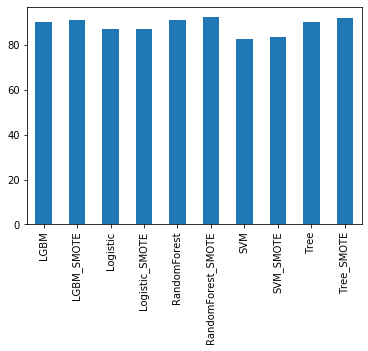

In [398]:
result["検証精度%"].plot(kind='bar');